In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt

import yfinance as finance_old

from scipy import stats

from tqdm.notebook import tqdm

import yahoo_fin.stock_info as finance

from simplejson.decoder import JSONDecodeError

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


#   Main Block started
class Generation:

    def __init__(self, based_symbol:str, show=False):
        self.based_symbol = based_symbol    #   Symbol storage
        #self.symbol_data = finance.download(self.based_symbol, start='2012-01-01', end="2018-01-01", progress=False, show_errors=False) #  Reference data
        self.symbol_data = finance.get_data(self.based_symbol, start_date='2012-01-01', end_date="2018-01-01") #  Reference data
        self.trend_line = None  #   Raw Trend
        self.trend_size = None  #   Raw Trend size
        self.walking = None #   Stochastic dataset
        self.final_trend_line = None    #   Buffer random walking
        self.final_size = None  #   Buffer random walking size
        self.final_with_std = None  #   Result of random walking algorithm
        self.final_size_std = None  #   Size result of random walking algorithm
        self.bootstrap_data = None  #   Raw dataset from bootstrap method
        self.combined_boot_trend = None #   All result

        self.collect_trend_line(info=False)
        if show:
            plt.figure(figsize=(8,4))
            #plt.plot(self.symbol_data["Open"])
            plt.plot(self.symbol_data["open"])
            plt.title('Input Raw Data')
            plt.show()


    def collect_trend_line(self, info=False):
        """
        Takes trend line from time-series data. It will help me to make more real dataset. So first parameter is BASED SYMBOL
        *Possible to replace with moving average line*
        :return:
        """
        if info:
            print('SHAPE INPUT', self.symbol_data.shape)

        #trend_buffer = self.symbol_data["Open"].squeeze().dropna()
        trend_buffer = self.symbol_data["open"].squeeze().dropna()
        trend_buffer = trend_buffer.asfreq('M')
        for _arrow_ in reversed(range(trend_buffer.shape[0] - 1)):
            if trend_buffer[_arrow_].astype(str) == 'nan':
                trend_buffer[_arrow_] = trend_buffer[_arrow_+1]

        if info:
            print(trend_buffer)

        components = tsa.seasonal_decompose(trend_buffer, model='additive')
        ts = (trend_buffer.to_frame('Original')
          .assign(Trend=components.trend)
          .assign(Residual=components.resid)).dropna()

        trend_buffer = ts["Trend"].asfreq('d')
        if info:
            print("TREND LEN:", len(trend_buffer))
        for i in reversed(range(trend_buffer.shape[0])):
            if trend_buffer[i].astype(str) == 'nan':
               trend_buffer[i] = trend_buffer[i+1]
        self.trend_line = trend_buffer
        self.trend_size = self.trend_line.shape[0] - 1
        del trend_buffer
        del components

    @classmethod
    def random_walking(cls, discrete_steps:int, continuous_steps:int, increment:float or int):
        """
        I will use it to create F(time) to input at NORMAL(TREND(time), F(time)).
        I make this in case that market time-series is not stationary row
        So this thing gives me ability to make STD function not equal in time
        :param discrete_steps: Usually will be int(365)
        :param continuous_steps:
        :param increment: STD parameter. At this step it is the most interesting parameter
        :return:
        """
        dt = 1 * continuous_steps / discrete_steps
        random_increment = np.random.normal(.0, increment, discrete_steps) * np.sqrt(dt)
        motion = np.cumsum(random_increment)
        motion = np.insert(motion, 0 , 0.0)
        return motion, random_increment


    def create_random_walking_line(self, info=True, show=True):
        """
        :param info: Print info about random array
        :param show: Show graphic
        :return:
        """
        motion_average_control = 7
        zero_log_control = 5


        self.walking = moving_average(np.log(abs(Generation.random_walking(discrete_steps=self.trend_size + motion_average_control + zero_log_control, continuous_steps=1,
                                                 increment=2)[0])[5:]), motion_average_control + 1)
        if info:
            print(f"--------\nMEAN: {self.walking.mean()}\nSTD: {self.walking.std()}")
        if show:
            plt.figure(figsize=(12,6))
            plt.grid()
            plt.plot(self.walking)
            plt.title('Random Walking')
            plt.show()


    def generate_new_trend_based_on_input(self, info=False, show=False):


        ### Not to change. Really dont touch it. Only few parameter, but better dont touch em too

        #average_approx_strength = 25 #  High strength parameter
        #average_approx_strength = 15 #  High strength parameter - 15 == Bigger Volatility
        average_approx_strength = 2
        smart_walking_smooth = 10

        frame = self.trend_line.to_frame()
        frame["Walk"] = self.walking
        #stdd = self.symbol_data["Open"].std()
        stdd = self.symbol_data["open"].std()
        #[stats.norm(x, stdd).rvs(size=self.trend_size) for x in self.walking]
        smart_walking = abs(np.array([stats.norm(x, stdd).rvs(1) for x in self.walking]))
        smart_walking = smart_walking.T[0]
        if info:
            print(smart_walking_smooth)
            print(stats.norm(self.walking[-1], stdd).rvs(smart_walking_smooth))
        smart_walking = np.hstack((smart_walking, abs(stats.norm(self.walking[-1], stdd).rvs(size=smart_walking_smooth))))
        if show:
            plt.figure(figsize=(12,4))
            plt.title('Smart random')
            plt.plot(smart_walking)
            plt.show()
            frame.columns = ['Trend', 'Walk']

        if show:
            plt.figure(figsize=(18,6))
            plt.title("Adding walk component to reference trend")
            plt.plot(frame["Trend"] + abs(np.cumsum((frame["Walk"]))))
            plt.show()

        move = moving_average(frame["Trend"] + abs(np.cumsum((frame["Walk"]))), average_approx_strength)
        move = move + (moving_average(smart_walking, smart_walking_smooth) * (max(move) / max(smart_walking)))[:len(move)]
        move = np.hstack((move, move[-(average_approx_strength - 1):]))

        frame["NORM"] = move

        if info:
            print(len(self.walking))
            print(len(frame))
            print(move)

        self.final_trend_line = frame.NORM[:-average_approx_strength]
        self.final_size = len(frame) - average_approx_strength
        if show:
            plt.figure(figsize=(18, 6))
            plt.title("MOVING AVERAGE: Adding walk component to reference trend")
            plt.plot(self.final_trend_line)
            plt.show()
        del frame
        del move

    def create_std_final_trend(self, show=True, weight = [.8, .2]):
        """

        :param show:
        :param weight: way to control how interesting result will be. I took that numbers to create something like reference
        :return:
        """
        average_approx_strength = 10 #  High strength parameter


        # FIXME:    Bad algorithm in new_array creation. Sometimes in creates huge volatility
        random = abs(Generation.random_walking(discrete_steps=self.final_size, continuous_steps=1, increment=70)[0][1:])
        new_array = []
        trend = self.final_trend_line
        for i in range(len(random)):
            new_array.append(weight[0] * trend[i] * weight[1] * 100 * random[i])

        new_array = moving_average(new_array, average_approx_strength) #    Problem solution is to use moving average
        #   May create some problems

        normalize_coff = max(new_array) / max(trend)
        #normalize_coff = new_array[0] / max(self.symbol_data["Open"])
        new_array = np.array(new_array) / normalize_coff

        #new_array = new_array + stats.norm(100, 50).rvs()

        #new_array = new_array + stats.norm(100, self.symbol_data["Open"].std()).rvs()
        new_array = new_array + stats.norm(100, self.symbol_data["open"].std()).rvs()


        #   stats.norm is: Simple way to set not_zero_start
        #   It will help me to create sync bootstrap method

        if show:
            fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,6))
            ax[0].set_title('TREND_LINE')
            ax[0].plot(self.final_trend_line.values)
            ax[1].set_title('TREND WITH STD')
            ax[1].plot(new_array)
            ax[2].set_title('REFERENCE LINE')
            #ax[2].plot(self.symbol_data["Open"][:self.final_size].values)
            ax[2].plot(self.symbol_data["open"][:self.final_size].values)

        self.final_with_std = new_array
        self.final_size_std = len(new_array)

    #   BLOCK WITH BOOTSTRAP METHOD
    def make_bootstrap_data(self, show=True, info=False):
        start_price = self.final_with_std[0]
        #all_samples = self.symbol_data["Open"].pct_change().dropna()
        all_samples = self.symbol_data["open"].pct_change().dropna()
        if info:
            print("START PRICE:", start_price)
            print(all_samples)
        prices = list()
        for _arrow_ in range(self.final_size_std):
            start_price *= (1 + np.random.choice(all_samples))
            prices.append(start_price)
        prices = prices / max(prices)
        if show:
            plt.figure(figsize=(12,4))
            plt.title('Bootstrap graph')
            plt.plot(prices)
            plt.show()
        self.bootstrap_data = prices

    def combine_trend_bootstrap(self, show=True, weights=[0.75, 0.25]):
        boot_trend = self.final_with_std * weights[0]  * weights[1] * (self.bootstrap_data / max(self.bootstrap_data))
        boot_trend = boot_trend / (boot_trend[0] / self.final_with_std[0])
        #boot_trend = boot_trend / (max(boot_trend) / max(self.symbol_data["Open"].values))
        #boot_trend = boot_trend / (boot_trend.mean() / self.symbol_data["Open"].values.mean())
        boot_trend = boot_trend / (boot_trend.mean() / self.symbol_data["open"].values.mean())
        if show:
            plt.figure(figsize=(12, 4))
            plt.title("SYNTH DATA")
            plt.plot(boot_trend)
            plt.show()
            plt.figure(figsize=(12, 4))
            plt.title("REAL DATA")
            #plt.plot(self.symbol_data["Open"].values[:self.final_size_std])
            plt.plot(self.symbol_data["open"].values[:self.final_size_std])
            plt.show()

        self.combined_boot_trend = abs(boot_trend)

#   Main Block end

In [15]:
'''
#SEED = 4 # Generates case i want to fix #FIXED
SEED = np.random.randint(0, 1000)
print(SEED)
#sber = Generation('SBER.ME')
sber = Generation('AAPL')
'''

"\n#SEED = 4 # Generates case i want to fix #FIXED\nSEED = np.random.randint(0, 1000)\nprint(SEED)\n#sber = Generation('SBER.ME')\nsber = Generation('AAPL')\n"

In [16]:
'''
np.random.seed(SEED)
#   Make this until we get what we likes
sber.create_random_walking_line(info=False, show=True)

#   Generate unique trend based little by reference
sber.generate_new_trend_based_on_input(info=False, show=True)
'''

'\nnp.random.seed(SEED)\n#   Make this until we get what we likes\nsber.create_random_walking_line(info=False, show=True)\n\n#   Generate unique trend based little by reference\nsber.generate_new_trend_based_on_input(info=False, show=True)\n'

In [17]:
"""np.random.seed(SEED)
#   Apply STD function to trend. Be careful sometimes works wrong #FIXED
sber.create_std_final_trend(show=True)

#   Starting Bootstrap method
sber.make_bootstrap_data(show=True)

#   Combining
sber.combine_trend_bootstrap(show=True)

print("SYNTH STD:", sber.combined_boot_trend.std())
print("REAL STD:", sber.symbol_data["Open"].values[:sber.final_size_std].std())
"""

'np.random.seed(SEED)\n#   Apply STD function to trend. Be careful sometimes works wrong #FIXED\nsber.create_std_final_trend(show=True)\n\n#   Starting Bootstrap method\nsber.make_bootstrap_data(show=True)\n\n#   Combining\nsber.combine_trend_bootstrap(show=True)\n\nprint("SYNTH STD:", sber.combined_boot_trend.std())\nprint("REAL STD:", sber.symbol_data["Open"].values[:sber.final_size_std].std())\n'

In [18]:
"""np.random.seed(SEED)
testing = pd.DataFrame(sber.combined_boot_trend, index=pd.date_range("2018-01-01", periods=len(sber.combined_boot_trend), freq="d"))
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(testing, color='blue')
plt.savefig("test.png")
plt.show()
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(sber.symbol_data["Open"].values, color='blue')
plt.show()"""

'np.random.seed(SEED)\ntesting = pd.DataFrame(sber.combined_boot_trend, index=pd.date_range("2018-01-01", periods=len(sber.combined_boot_trend), freq="d"))\nplt.figure(figsize=(16,8))\nplt.grid()\nplt.plot(testing, color=\'blue\')\nplt.savefig("test.png")\nplt.show()\nplt.figure(figsize=(16,8))\nplt.grid()\nplt.plot(sber.symbol_data["Open"].values, color=\'blue\')\nplt.show()'

In [19]:
"""#np.random.seed(SEED)
LEN_DATASET = 180
idx = np.random.randint(0, len(sber.symbol_data["Open"].values) - LEN_DATASET)
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.title('REAL')
plt.plot(sber.symbol_data['Open'].values[idx:idx+LEN_DATASET])
plt.subplot(2,1,2)
plt.title('SYNTH')
plt.plot(sber.combined_boot_trend[idx:idx+LEN_DATASET])
"""

'#np.random.seed(SEED)\nLEN_DATASET = 180\nidx = np.random.randint(0, len(sber.symbol_data["Open"].values) - LEN_DATASET)\nplt.figure(figsize=(16,10))\nplt.subplot(2,1,1)\nplt.title(\'REAL\')\nplt.plot(sber.symbol_data[\'Open\'].values[idx:idx+LEN_DATASET])\nplt.subplot(2,1,2)\nplt.title(\'SYNTH\')\nplt.plot(sber.combined_boot_trend[idx:idx+LEN_DATASET])\n'

In [3]:
def create_dataset(iteration, show=False, symbol='AAPL', traceback=False):
    try:
        dataset = Generation(symbol)
    except JSONDecodeError:
        if traceback:
            print('JSON TROUBLE (Yahoo side):', symbol)
            print('------------------------------------------')
        return None
    except (AssertionError, KeyError):
        if traceback:
            print('Unavailable to download data for:', symbol)
            print('Possible company not exists at this period')
            print('------------------------------------------')
        return None
    except ValueError:
        if traceback:
            print('Empty values comes for trend collector:', symbol)
            print('------------------------------------------')
        return None

    dataset.create_random_walking_line(info=False, show=False)

    dataset.generate_new_trend_based_on_input(info=False, show=False)
    dataset.create_std_final_trend(show=False)

    dataset.make_bootstrap_data(show=False)

    dataset.combine_trend_bootstrap(show=False)
    testing_func = pd.DataFrame(dataset.combined_boot_trend, index=pd.date_range("2018-01-01", periods=len(dataset.combined_boot_trend), freq="d"))
    if show:
        plt.figure(figsize=(16,8))
        plt.grid()
        plt.title(str(iteration))
        plt.plot(testing_func, color='blue')
        plt.show()
    if len(dataset.combined_boot_trend) >= 365:
        return dataset.combined_boot_trend[:365]
    else:
        if traceback:
            print('Small data for:', symbol)
        return None

  0%|          | 0/8100 [00:00<?, ?it/s]

Small data for: AC
Small data for: ACBI
Small data for: AGR
Small data for: AXSM
Small data for: BRQS
Small data for: CCNC
Small data for: DLTH
Small data for: DSKE
Small data for: EQBK
Small data for: FCPT
Small data for: LMFA
Small data for: MIME
Small data for: MTBCP
Small data for: MTP
Small data for: OCX
Small data for: PLYA
Small data for: PPBT
Small data for: PXS
Small data for: RMR
Small data for: SENS
Small data for: SQ
Small data for: TEAM
Small data for: TKAT
Small data for: TWNK
Small data for: TWNKW
Small data for: VYGR
Small data for: WSC
Small data for: WVE
Small data for: YRD
ERRORS 3979 OF TOTAL 8100


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_3109/3675981019.py:219: RuntimeWarning: invalid value encountered in true_divide
  prices = prices / max(prices)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_3109/3675981019.py:228: RuntimeWarning: invalid value encountered in true_divide
  boot_trend = self.final_with_std * weights[0]  * weights[1] * (self.bootstrap_data / max(self.bootstrap_data))


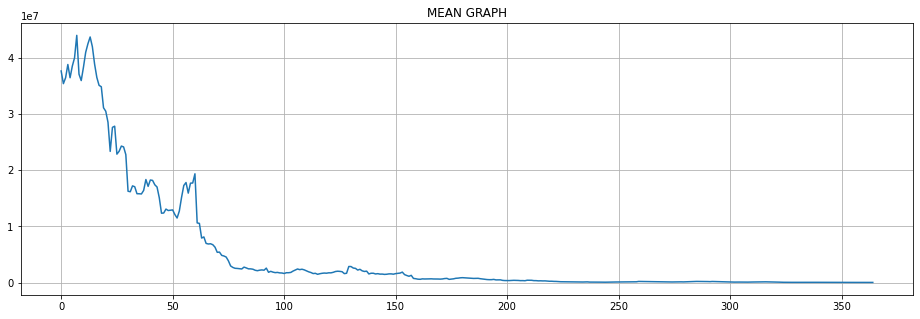

In [8]:
SAMPLES = 8100

ERRORS_STAT = 0
STOCKS_LIST = pd.read_csv('nasdaq_screener_1631906785700.csv', header=0, index_col=None)['Symbol'].values
final_dataset = pd.DataFrame()
for _it_ in tqdm(STOCKS_LIST[:SAMPLES], total=SAMPLES):
    func_ret = create_dataset(_it_, symbol=_it_, traceback=False)
    if not func_ret is None:
        #final_dataset[f'Symbol_{_it_}'] = pd.Series(func_ret)
        final_dataset = pd.concat([final_dataset, pd.Series(func_ret, name=f"Symbol_{_it_}")], axis=1)
    if func_ret is None:
        ERRORS_STAT += 1
plt.figure(figsize=(16,5))
plt.title('MEAN GRAPH')
plt.plot(final_dataset[:365].agg('mean', axis=1))
plt.grid()
plt.show()
print(f'ERRORS {ERRORS_STAT} OF TOTAL {SAMPLES}')

In [7]:
final_dataset.to_csv('generate_dataset')
























  0%|          | 0/100 [00:00<?, ?it/s]

Unavailable to download data for: AAC
Possible company not exists at this period
Unavailable to download data for: AADI
Possible company not exists at this period
Unavailable to download data for: AAIC^B
Possible company not exists at this period
Unavailable to download data for: AAIC^C
Possible company not exists at this period
Unavailable to download data for: AAIN
Possible company not exists at this period
Unavailable to download data for: AAN
Possible company not exists at this period
Unavailable to download data for: AAQC
Possible company not exists at this period
Unavailable to download data for: ABCL
Possible company not exists at this period
Unavailable to download data for: ABCM
Possible company not exists at this period
Unavailable to download data for: ABGI
Possible company not exists at this period
Unavailable to download data for: ABNB
Possible company not exists at this period
Unavailable to download data for: ABOS
Possible company not exists at this period
Unavailable to

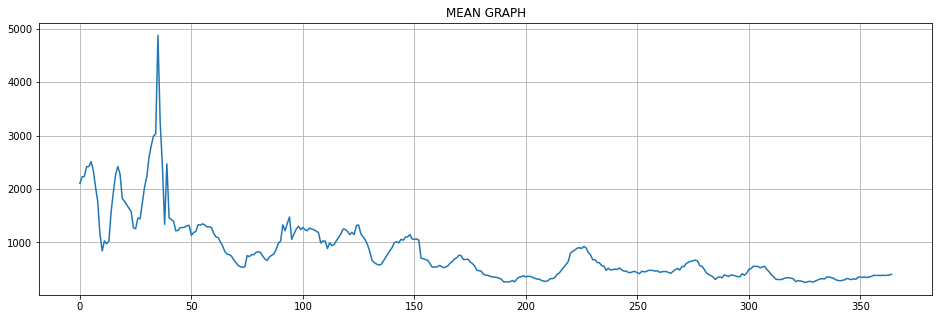

In [41]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


#   Main Block started
class Generation_OLD:

    def __init__(self, based_symbol:str, show=False):
        self.based_symbol = based_symbol    #   Symbol storage
        #self.symbol_data = finance.download(self.based_symbol, start='2012-01-01', end="2018-01-01", progress=False, show_errors=False) #  Reference data
        self.symbol_data = finance_old.download(self.based_symbol, start='2012-01-01', end="2018-01-01", progress=False, show_errors=False) #  Reference data
        self.trend_line = None  #   Raw Trend
        self.trend_size = None  #   Raw Trend size
        self.walking = None #   Stochastic dataset
        self.final_trend_line = None    #   Buffer random walking
        self.final_size = None  #   Buffer random walking size
        self.final_with_std = None  #   Result of random walking algorithm
        self.final_size_std = None  #   Size result of random walking algorithm
        self.bootstrap_data = None  #   Raw dataset from bootstrap method
        self.combined_boot_trend = None #   All result

        self.collect_trend_line(info=False)
        if show:
            plt.figure(figsize=(8,4))
            plt.plot(self.symbol_data["Open"])
            plt.title('Input Raw Data')
            plt.show()


    def collect_trend_line(self, info=False):
        """
        Takes trend line from time-series data. It will help me to make more real dataset. So first parameter is BASED SYMBOL
        *Possible to replace with moving average line*
        :return:
        """
        if info:
            print('SHAPE INPUT', self.symbol_data.shape)

        trend_buffer = self.symbol_data["Open"].squeeze().dropna()
        trend_buffer = trend_buffer.asfreq('M')
        for _arrow_ in reversed(range(trend_buffer.shape[0] - 1)):
            if trend_buffer[_arrow_].astype(str) == 'nan':
                trend_buffer[_arrow_] = trend_buffer[_arrow_+1]

        if info:
            print(trend_buffer)

        components = tsa.seasonal_decompose(trend_buffer, model='additive')
        ts = (trend_buffer.to_frame('Original')
          .assign(Trend=components.trend)
          .assign(Residual=components.resid)).dropna()

        trend_buffer = ts["Trend"].asfreq('d')
        if info:
            print("TREND LEN:", len(trend_buffer))
        for i in reversed(range(trend_buffer.shape[0])):
            if trend_buffer[i].astype(str) == 'nan':
               trend_buffer[i] = trend_buffer[i+1]
        self.trend_line = trend_buffer
        self.trend_size = self.trend_line.shape[0] - 1
        del trend_buffer
        del components

    @classmethod
    def random_walking(cls, discrete_steps:int, continuous_steps:int, increment:float or int):
        """
        I will use it to create F(time) to input at NORMAL(TREND(time), F(time)).
        I make this in case that market time-series is not stationary row
        So this thing gives me ability to make STD function not equal in time
        :param discrete_steps: Usually will be int(365)
        :param continuous_steps:
        :param increment: STD parameter. At this step it is the most interesting parameter
        :return:
        """
        dt = 1 * continuous_steps / discrete_steps
        random_increment = np.random.normal(.0, increment, discrete_steps) * np.sqrt(dt)
        motion = np.cumsum(random_increment)
        motion = np.insert(motion, 0 , 0.0)
        return motion, random_increment


    def create_random_walking_line(self, info=True, show=True):
        """
        :param info: Print info about random array
        :param show: Show graphic
        :return:
        """
        motion_average_control = 7
        zero_log_control = 5


        self.walking = moving_average(np.log(abs(Generation.random_walking(discrete_steps=self.trend_size + motion_average_control + zero_log_control, continuous_steps=1,
                                                 increment=2)[0])[5:]), motion_average_control + 1)
        if info:
            print(f"--------\nMEAN: {self.walking.mean()}\nSTD: {self.walking.std()}")
        if show:
            plt.figure(figsize=(12,6))
            plt.grid()
            plt.plot(self.walking)
            plt.title('Random Walking')
            plt.show()


    def generate_new_trend_based_on_input(self, info=False, show=False):


        ### Not to change. Really dont touch it. Only few parameter, but better dont touch em too

        #average_approx_strength = 25 #  High strength parameter
        #average_approx_strength = 15 #  High strength parameter - 15 == Bigger Volatility
        average_approx_strength = 2
        smart_walking_smooth = 10

        frame = self.trend_line.to_frame()
        frame["Walk"] = self.walking
        stdd = self.symbol_data["Open"].std()
        #[stats.norm(x, stdd).rvs(size=self.trend_size) for x in self.walking]
        smart_walking = abs(np.array([stats.norm(x, stdd).rvs(1) for x in self.walking]))
        smart_walking = smart_walking.T[0]
        if info:
            print(smart_walking_smooth)
            print(stats.norm(self.walking[-1], stdd).rvs(smart_walking_smooth))
        smart_walking = np.hstack((smart_walking, abs(stats.norm(self.walking[-1], stdd).rvs(size=smart_walking_smooth))))
        if show:
            plt.figure(figsize=(12,4))
            plt.title('Smart random')
            plt.plot(smart_walking)
            plt.show()
            frame.columns = ['Trend', 'Walk']

        if show:
            plt.figure(figsize=(18,6))
            plt.title("Adding walk component to reference trend")
            plt.plot(frame["Trend"] + abs(np.cumsum((frame["Walk"]))))
            plt.show()

        move = moving_average(frame["Trend"] + abs(np.cumsum((frame["Walk"]))), average_approx_strength)
        move = move + (moving_average(smart_walking, smart_walking_smooth) * (max(move) / max(smart_walking)))[:len(move)]
        move = np.hstack((move, move[-(average_approx_strength - 1):]))

        frame["NORM"] = move

        if info:
            print(len(self.walking))
            print(len(frame))
            print(move)

        self.final_trend_line = frame.NORM[:-average_approx_strength]
        self.final_size = len(frame) - average_approx_strength
        if show:
            plt.figure(figsize=(18, 6))
            plt.title("MOVING AVERAGE: Adding walk component to reference trend")
            plt.plot(self.final_trend_line)
            plt.show()
        del frame
        del move

    def create_std_final_trend(self, show=True, weight = [.8, .2]):
        """

        :param show:
        :param weight: way to control how interesting result will be. I took that numbers to create something like reference
        :return:
        """
        average_approx_strength = 10 #  High strength parameter


        # FIXME:    Bad algorithm in new_array creation. Sometimes in creates huge volatility
        random = abs(Generation.random_walking(discrete_steps=self.final_size, continuous_steps=1, increment=70)[0][1:])
        new_array = []
        trend = self.final_trend_line
        for i in range(len(random)):
            new_array.append(weight[0] * trend[i] * weight[1] * 100 * random[i])

        new_array = moving_average(new_array, average_approx_strength) #    Problem solution is to use moving average
        #   May create some problems

        normalize_coff = max(new_array) / max(trend)
        #normalize_coff = new_array[0] / max(self.symbol_data["Open"])
        new_array = np.array(new_array) / normalize_coff

        #new_array = new_array + stats.norm(100, 50).rvs()

        new_array = new_array + stats.norm(100, self.symbol_data["Open"].std()).rvs()


        #   stats.norm is: Simple way to set not_zero_start
        #   It will help me to create sync bootstrap method

        if show:
            fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,6))
            ax[0].set_title('TREND_LINE')
            ax[0].plot(self.final_trend_line.values)
            ax[1].set_title('TREND WITH STD')
            ax[1].plot(new_array)
            ax[2].set_title('REFERENCE LINE')
            ax[2].plot(self.symbol_data["Open"][:self.final_size].values)

        self.final_with_std = new_array
        self.final_size_std = len(new_array)

    #   BLOCK WITH BOOTSTRAP METHOD
    def make_bootstrap_data(self, show=True, info=False):
        start_price = self.final_with_std[0]
        all_samples = self.symbol_data["Open"].pct_change().dropna()
        if info:
            print("START PRICE:", start_price)
            print(all_samples)
        prices = list()
        for _arrow_ in range(self.final_size_std):
            start_price *= (1 + np.random.choice(all_samples))
            prices.append(start_price)
        prices = prices / max(prices)
        if show:
            plt.figure(figsize=(12,4))
            plt.title('Bootstrap graph')
            plt.plot(prices)
            plt.show()
        self.bootstrap_data = prices

    def combine_trend_bootstrap(self, show=True, weights=[0.75, 0.25]):
        boot_trend = self.final_with_std * weights[0]  * weights[1] * (self.bootstrap_data / max(self.bootstrap_data))
        boot_trend = boot_trend / (boot_trend[0] / self.final_with_std[0])
        #boot_trend = boot_trend / (max(boot_trend) / max(self.symbol_data["Open"].values))
        boot_trend = boot_trend / (boot_trend.mean() / self.symbol_data["Open"].values.mean())
        if show:
            plt.figure(figsize=(12, 4))
            plt.title("SYNTH DATA")
            plt.plot(boot_trend)
            plt.show()
            plt.figure(figsize=(12, 4))
            plt.title("REAL DATA")
            #plt.plot(self.symbol_data["Open"].values[:self.final_size_std])
            plt.plot(self.symbol_data["open"].values[:self.final_size_std])
            plt.show()

        self.combined_boot_trend = abs(boot_trend)

#   Main Block end

def create_dataset_OLD(iteration, show=False, symbol='AAPL', traceback=False):
    try:
        dataset = Generation_OLD(symbol)
    except JSONDecodeError:
        if traceback:
            print('JSON TROUBLE (Yahoo side):', symbol)
            print('------------------------------------------')
        return None
    except (AssertionError, KeyError):
        if traceback:
            print('Unavailable to download data for:', symbol)
            print('Possible company not exists at this period')
            print('------------------------------------------')
        return None
    except ValueError:
        if traceback:
            print('Empty values comes for trend collector:', symbol)
            print('------------------------------------------')
        return None

    dataset.create_random_walking_line(info=False, show=False)

    dataset.generate_new_trend_based_on_input(info=False, show=False)
    dataset.create_std_final_trend(show=False)

    dataset.make_bootstrap_data(show=False)

    dataset.combine_trend_bootstrap(show=False)
    testing_func = pd.DataFrame(dataset.combined_boot_trend, index=pd.date_range("2018-01-01", periods=len(dataset.combined_boot_trend), freq="d"))
    if show:
        plt.figure(figsize=(16,8))
        plt.grid()
        plt.title(str(iteration))
        plt.plot(testing_func, color='blue')
        plt.show()
    if len(dataset.combined_boot_trend) >= 365:
        return dataset.combined_boot_trend[:365]
    else:
        print('Small data for:', symbol)
        return None

SAMPLES = 100

ERRORS_STAT = 0
STOCKS_LIST = pd.read_csv('nasdaq_screener_1631906785700.csv', header=0, index_col=None)['Symbol'].values
final_dataset = pd.DataFrame()
for _it_ in tqdm(STOCKS_LIST[:SAMPLES], total=SAMPLES):
    func_ret = create_dataset(_it_, symbol=_it_, traceback=True)
    if not func_ret is None:
        #final_dataset[f'Symbol_{_it_}'] = pd.Series(func_ret)
        final_dataset = pd.concat([final_dataset, pd.Series(func_ret, name=f"Symbol_{_it_}")], axis=1)
    if func_ret is None:
        ERRORS_STAT += 1
plt.figure(figsize=(16,5))
plt.title('MEAN GRAPH')
plt.plot(final_dataset[:365].agg('mean', axis=1))
plt.grid()
plt.show()
print(f'ERRORS {ERRORS_STAT} OF TOTAL {SAMPLES}')